In [1]:
import os
from pathlib import Path
import zipfile
import urllib
import opendatasets as od
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from sklearn.utils import shuffle
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import shutil
import os

In [2]:
path = 'data/credit-data.csv'
isExisting = os.path.exists(path)

if not isExisting:
    od.download(
        "https://www.kaggle.com/datasets/kelvinkelue/credit-card-fraud-prediction/download?datasetVersionNumber=1")
    Path("data/").mkdir(parents=True, exist_ok=True)
    shutil.move(src="credit-card-fraud-prediction/fraud test.csv", dst="data/credit-data.csv")
    shutil.rmtree("credit-card-fraud-prediction")

In [3]:
from pandas import DataFrame


file= 'data/credit-data.csv'
fraud_data: DataFrame = pd.read_csv(file)
fraud_data: DataFrame = shuffle(fraud_data)

In [4]:
fraud_data

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
484358,484358,15/12/2020 19:09,4.334230e+15,fraud_Leffler-Goldner,personal_care,24.30,Scott,Martin,M,7483 Navarro Flats,...,43.0172,-111.0292,471,"Education officer, museum",02/08/1967,922fb60c19d13dff6ae5f8a584c409c7,1387134564,42.330286,-111.620242,0
21340,21340,28/06/2020 20:01,4.430880e+15,"fraud_Schneider, Hayes and Nikolaus",food_dining,36.61,Alicia,Morales,F,4456 Dunn Roads,...,39.3199,-106.6596,61,Public relations account executive,04/11/1939,ba7b90194282913593b5b0608c9e24f6,1372449672,39.257072,-106.080304,0
310949,310949,17/10/2020 16:17,4.635330e+15,fraud_Reilly and Sons,health_fitness,6.04,Christina,Rose,F,1984 Taylor Island Suite 836,...,38.8856,-77.1802,116155,Chartered accountant,10/07/1983,fff4d2db394af93686ed94b8509bd09e,1382026621,39.207052,-77.848613,0
143644,143644,10/08/2020 14:20,6.011720e+15,fraud_Gislason Group,travel,1188.64,Ann,Lawson,F,144 Evans Islands Apt. 683,...,46.1966,-118.9017,3684,Musician,29/11/1981,891e6e12d5406659fb701c5a4b6b0b93,1376144400,46.736160,-118.127454,0
552570,552570,31/12/2020 02:00,1.800650e+14,fraud_Dooley-Thompson,misc_net,129.65,Patricia,Gonzalez,F,8973 Mark Drive,...,37.9048,-86.5240,344,Chartered public finance accountant,30/03/1967,be58178837b93d7aab6e635cceb0abe1,1388455208,37.086010,-85.779585,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438479,438479,06/12/2020 12:54,6.011540e+15,fraud_Ruecker-Mayert,kids_pets,99.23,Emily,Hall,F,8851 Reese Neck,...,38.8089,-78.7776,863,"Engineer, mining",09/08/1972,83e8ecb9365b4760feca656912c53ea0,1386334481,38.057895,-78.747373,0
505895,505895,21/12/2020 02:53,3.506040e+15,"fraud_Reichert, Huels and Hoppe",shopping_net,1.71,Christine,Burns,F,343 Hannah Parkway,...,38.1372,-81.5962,630,Fine artist,30/07/1959,4ccecd8956d104755a78d0ce6b970802,1387594407,38.621270,-82.213080,0
345806,345806,01/11/2020 20:34,6.011650e+15,fraud_Simonis-Prohaska,misc_pos,217.62,Kathryn,Smith,F,19838 Tonya Prairie Apt. 947,...,38.2911,-92.7059,1847,Tax inspector,26/10/1988,41e9c54f71c7f067e6d4ce097e36e296,1383338042,37.865455,-92.864805,0
234330,234330,13/09/2020 22:41,6.759900e+11,fraud_Kub-Heaney,health_fitness,5.95,Amanda,Spencer,F,6682 Green Forks,...,41.0767,-74.5982,2456,Senior tax professional/tax inspector,13/03/1994,48c4b8a7440b44fc57a0766651c322a9,1379112085,40.606839,-74.288235,0


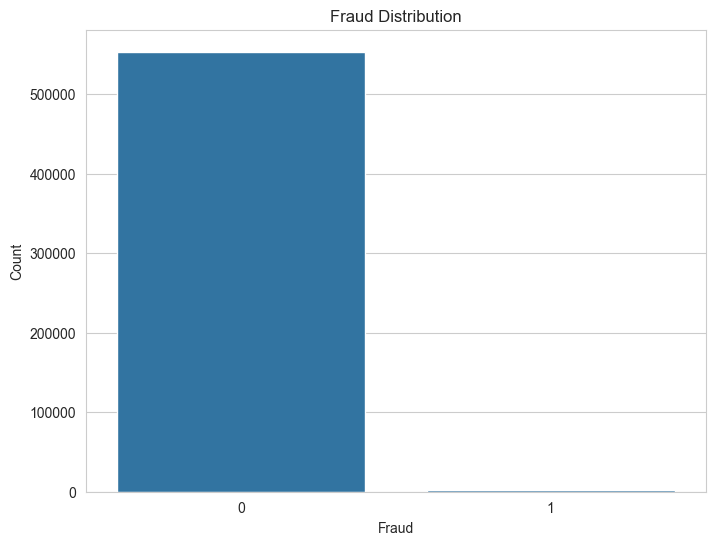

,is_fraud,count
0,0,553574
1,1,2145


In [5]:
fraud_counts = fraud_data['is_fraud'].value_counts()
fraud_counts_df = pd.DataFrame({'is_fraud': fraud_counts.index, 'count': fraud_counts.values})

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(x='is_fraud', y='count', data=fraud_counts_df)
plt.title('Fraud Distribution')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

fraud_counts_df

In [6]:
#Zwracamy typy danych dla każdej kolumny, przydatne przy przygotowywaniu danych
print("----------------------Typy danych")
print(fraud_data.dtypes) 

#Zwraca statystyki dla kolumny numerycznych jak średnia mediana itp, to może się przydać do oczyszczania danych numerycznych
print("----------------------Statystyki dla kolumn numerycznych")
print(fraud_data.describe()) 

----------------------Typy danych
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                   float64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object
----------------------Statystyki dla kolumn numerycznych
          Unnamed: 0        cc_num            amt            zip  \
count  555719.000000  5.557190e+05  555719.000000  555719.000000   


C:\Users\jaros\AppData\Local\Temp\ipykernel_37876\569064604.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(filename=gpd.datasets.get_path('naturalearth_lowres'))


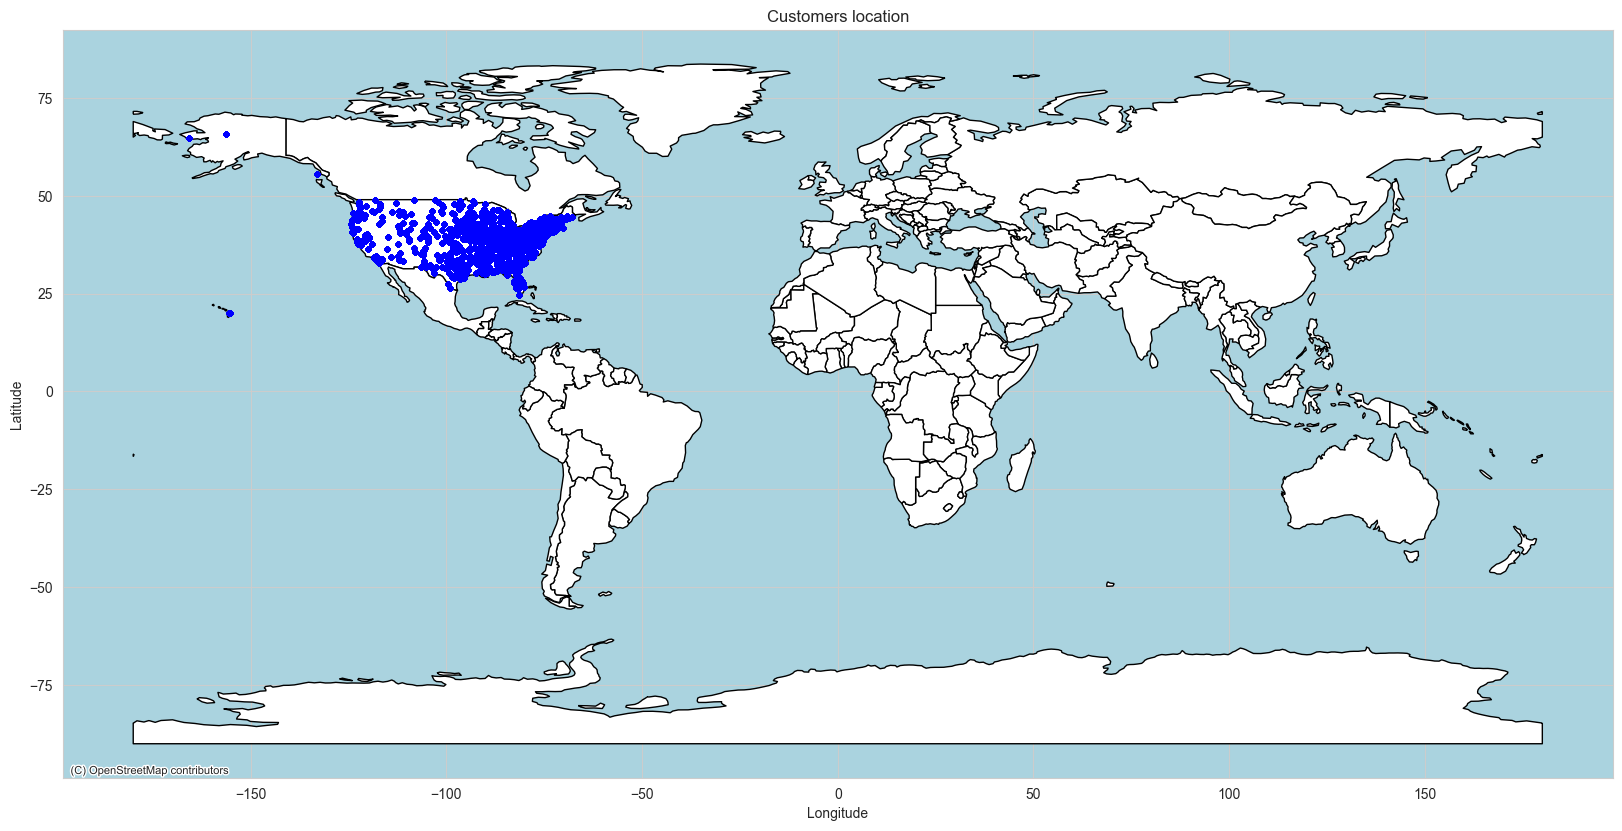

In [7]:
# Create a GeoDataFrame from DataFrame with latitude and longitude
gdf = gpd.GeoDataFrame(fraud_data, geometry=gpd.points_from_xy(fraud_data.long, fraud_data.lat))

# Plot world map
world = gpd.read_file(filename=gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20, 15), color='white', edgecolor='black')

# Plot latitude and longitude points on the world map
gdf.plot(ax=ax, color='blue', markersize=10)

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Customers location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

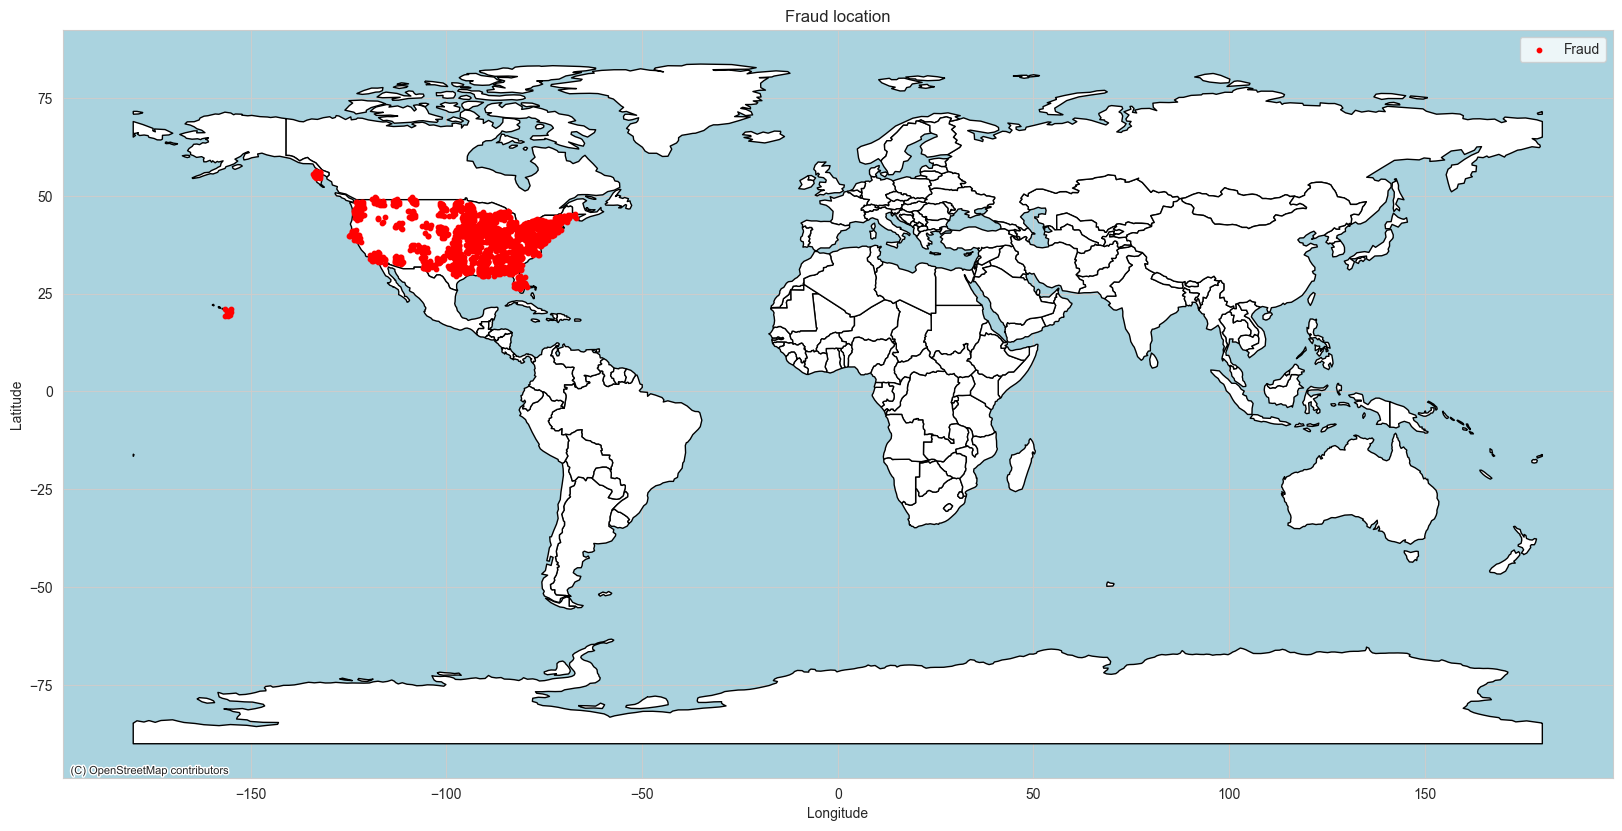

In [8]:
# Create a GeoDataFrame from DataFrame with latitude and longitude
gdf = gpd.GeoDataFrame(fraud_data, geometry=gpd.points_from_xy(fraud_data.merch_long, fraud_data.merch_lat))

# Filter points where is_fraud is 1
fraud_points = gdf[gdf['is_fraud'] == 1]

ax = world.plot(figsize=(20, 15), color='white', edgecolor='black')

# Plot latitude and longitude points on the world map
fraud_points.plot(ax=ax, color='red', markersize=10, label='Fraud')

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Fraud location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [9]:
# Define a function to categorize time periods
def categorize_time_period(timestamp):
    hour = timestamp.hour
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 16:
        return 'afternoon'  # change from noon to afternoon
    elif 16 <= hour < 20:
        return 'evening'
    else:
        return 'night'

In [10]:
# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Calculate differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Calculate distance
    distance = R * c
    return distance

In [11]:
#Convert 'trans_date_trans_time' column to datetime format
fraud_data['trans_date_trans_time'] = pd.to_datetime(fraud_data['trans_date_trans_time'], format='%d/%m/%Y %H:%M')

# Add time period 
fraud_data['time_period'] = fraud_data['trans_date_trans_time'].apply(categorize_time_period)

# Add day of the week
fraud_data['day_of_week'] = fraud_data['trans_date_trans_time'].dt.day_name()

# Number of transactions per customer
fraud_data['num_of_transactions'] = fraud_data.groupby('cc_num').cumcount() + 1

# Convert 'dob' column to datetime and extract year
dob_year = pd.to_datetime(fraud_data['dob'], format='%d/%m/%Y').dt.year

# Convert 'trans_date_trans_time' column to datetime and extract year
trans_year = pd.to_datetime(fraud_data['trans_date_trans_time']).dt.year

# Calculate age of the customer
fraud_data['age_of_user'] = trans_year - dob_year

# Calculate distance and create 'distance' column
fraud_data['distance'] = haversine(fraud_data['lat'], fraud_data['long'], fraud_data['merch_lat'], fraud_data['merch_long'])


In [12]:
#Usuwamy kolumny z unikatowymi identyfikatorami
fraud_data.drop('Unnamed: 0', axis=1, inplace=True)
fraud_data.drop('trans_num', axis=1, inplace=True)

#Imie i nazwisko jest nam nie potrzebne bo mamy cc_num
fraud_data.drop('first', axis=1, inplace=True)
fraud_data.drop('last', axis=1, inplace=True)

#dane juz nie potrzebne, bo przekształcone 
fraud_data.drop(columns=['trans_date_trans_time', 'dob', 'cc_num', 'lat', 'long', 'merch_lat', 'merch_long'], inplace=True)

#te dane są kategoryczne o zbyt duze licznie unikalnych wartości aby ich uzyc - moze da się jakoś je przetworzyć?
fraud_data.drop(columns=['merchant', 'city', 'job', 'street'], inplace=True)

fraud_data.drop(columns=['zip', 'unix_time'], inplace=True)

<Axes: >

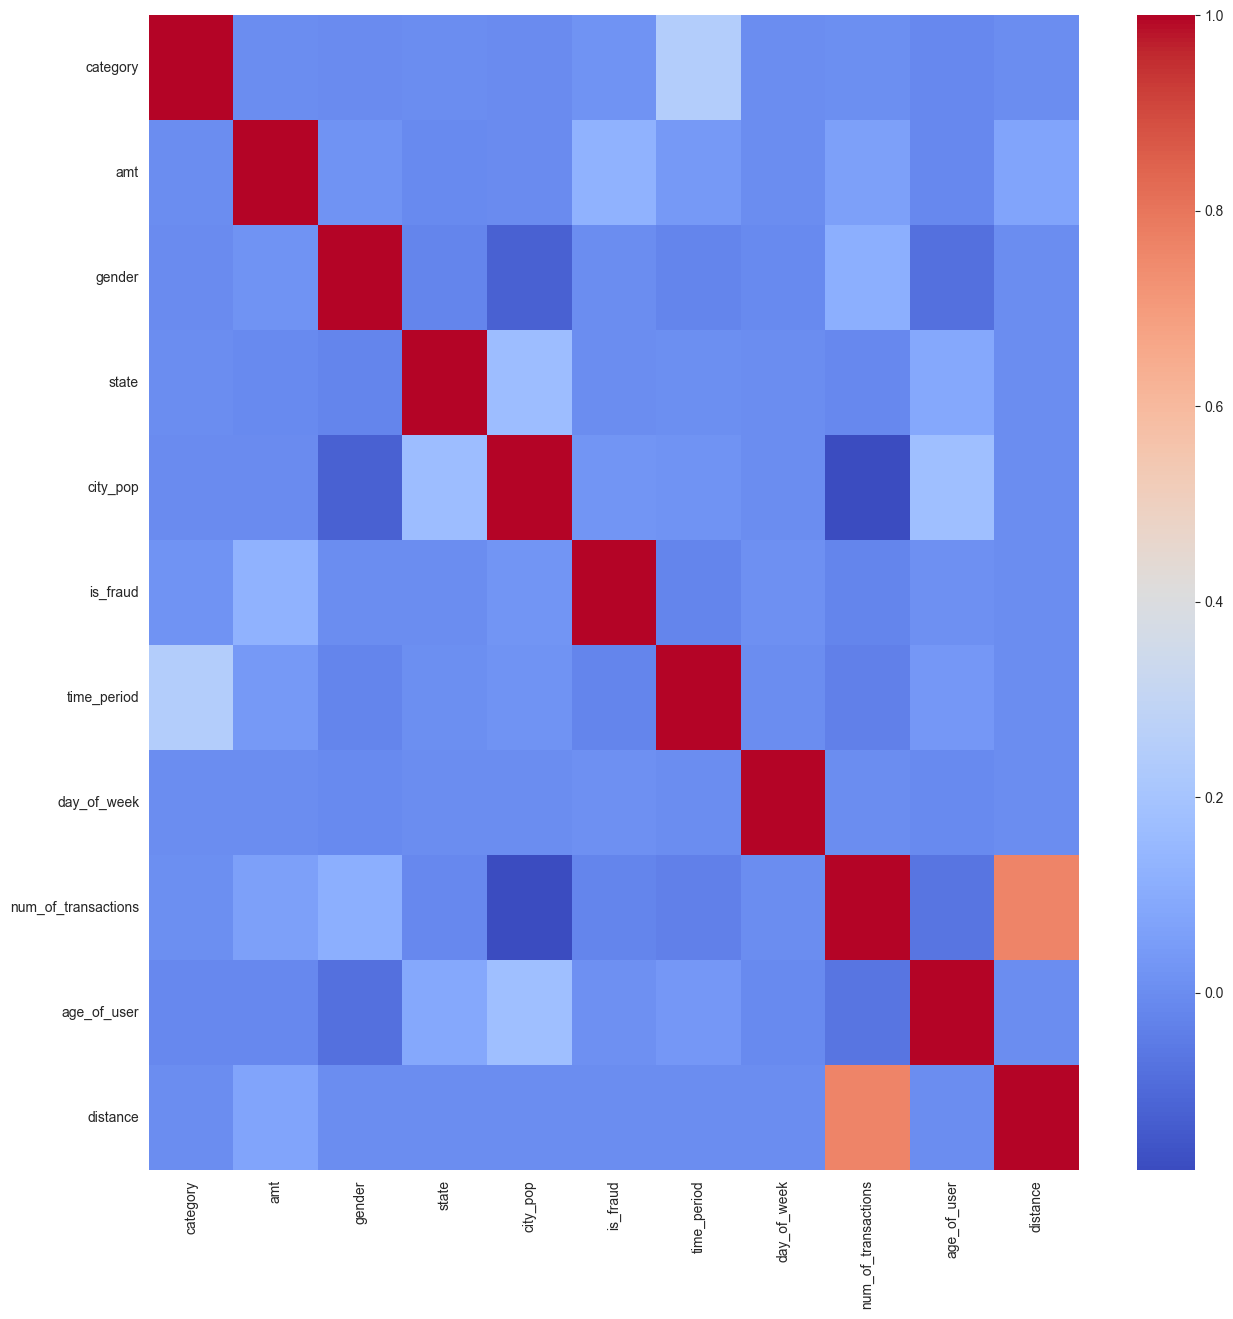

In [13]:
plt.figure(figsize=(15, 15))
corr = fraud_data[lambda fraud_data:[c for c in fraud_data.columns]].apply(lambda x : pd.factorize(x)[0]).corr()
sns.heatmap(corr.loc[lambda df:[c for c in fraud_data.columns],lambda fraud_data:[c for c in fraud_data.columns]],cmap='coolwarm')

In [14]:
Y = fraud_data[['is_fraud']]
X = fraud_data.drop(columns=['is_fraud'])

In [15]:
# cechy o typach nie numerycznych
cat_columns = X.select_dtypes(exclude=["bool_","number"]).columns.values.tolist()

# szukamy również danych o charakterze kategorycznym zapisanych w kolumnach numerycznych poprzez wyszukanie kolumn o małych zbiorach wartości unikalnych
for col in X.select_dtypes(include=["number"]).columns:
    c_uniq = len(X[col].unique())
    if  c_uniq > 2:
        print(f'{col}: {c_uniq}')

amt: 37256
city_pop: 835
num_of_transactions: 2144
age_of_user: 81
distance: 555719


In [16]:
cat_transformer_X = make_column_transformer(
    (OneHotEncoder(sparse_output=False), cat_columns),
    sparse_threshold= 0,
    verbose_feature_names_out=False,
    remainder='drop')

ohe_df = pd.DataFrame(cat_transformer_X.fit_transform(X), columns=cat_transformer_X.get_feature_names_out())
X = pd.concat([X.reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1).drop(cat_columns, axis=1)

X.shape

(555719, 82)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 5, stratify=Y['is_fraud'])

In [18]:
# Dictionary to store number of unique values for each column
num_unique_values = {}

# Calculate number of unique values for each column in the DataFrame
for col in fraud_data.columns:
    if col in cat_columns:
        num_unique_values[col] = fraud_data[col].nunique()

# Display the number of unique values for each categorical column
for col, num_unique in num_unique_values.items():
    print(f"Number of unique values in column '{col}': {num_unique}")

Number of unique values in column 'category': 14
Number of unique values in column 'gender': 2
Number of unique values in column 'state': 50
Number of unique values in column 'time_period': 4
Number of unique values in column 'day_of_week': 7


In [19]:
cat_columns

['category', 'gender', 'state', 'time_period', 'day_of_week']

In [20]:
quant_columns = [ c for c in X_train.columns if c not in cat_columns and c not in cat_transformer_X.get_feature_names_out()]
#print(quant_columns)
std_scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[quant_columns] = std_scaler.fit_transform(X_train[quant_columns])
X_test_scaled[quant_columns] = std_scaler.transform(X_test[quant_columns])

X_train_scaled.describe()

,amt,city_pop,num_of_transactions,age_of_user,distance,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,...,time_period_evening,time_period_morning,time_period_night,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
count,4.445750e+05,4.445750e+05,4.445750e+05,4.445750e+05,4.445750e+05,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,...,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000
mean,2.755386e-17,5.945496e-18,1.053008e-16,-1.592018e-16,2.696091e-16,0.072319,0.070708,0.101227,0.034779,0.094569,...,0.202922,0.226866,0.367807,0.112685,0.207029,0.112053,0.167470,0.107073,0.198731,0.094958
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.259015,0.256337,0.301629,0.183221,0.292619,...,0.402175,0.418806,0.482209,0.316208,0.405177,0.315432,0.373395,0.309206,0.399046,0.293157
min,-4.380919e-01,-2.939494e-01,-1.319465e+00,-1.816334e+00,-2.607577e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.828345e-01,-2.915670e-01,-8.069447e-01,-7.827111e-01,-7.144851e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.418276e-01,-2.860358e-01,-2.024339e-01,-9.362907e-02,7.220550e-02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.701361e-02,-2.287099e-01,6.156268e-01,6.528764e-01,7.694394e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.453385e+02,9.350542e+00,5.721114e+00,2.834969e+00,2.569475e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
X_train_scaled

,amt,city_pop,num_of_transactions,age_of_user,distance,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,...,time_period_evening,time_period_morning,time_period_night,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
111420,0.342427,0.052365,-0.921933,1.341958,1.433279,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
516134,0.510248,-0.285512,0.073538,0.882570,-1.202347,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
334174,-0.349603,-0.293170,0.047255,0.710300,0.819182,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
390028,0.221539,-0.293724,-0.261571,0.652876,0.099197,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
425527,-0.424005,-0.290001,1.568388,-1.012405,0.884317,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384586,-0.002756,-0.289072,0.172100,-0.667864,0.548772,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
422131,-0.305615,-0.288166,1.910068,-0.151053,0.829113,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
433762,-0.386420,-0.278587,4.121132,-1.356946,0.651765,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
342256,0.378604,-0.293389,0.027543,0.538029,-0.353858,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
Y_train

,is_fraud
335514,0
154397,0
170957,0
417795,0
152366,0
...,...
366205,0
310689,0
199773,0
217930,0


In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = 'auto')

n = 1000
X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)

Y_sampled = Y_train.groupby('is_fraud', group_keys=False).apply(lambda x: x.sample(min(len(x), n), replace=False))
X_sampled = X_train.loc[Y_sampled.index]

X_resampled, Y_resampled = smote.fit_resample(X_sampled, Y_sampled['is_fraud'])

X_resampled

C:\Users\jaros\AppData\Local\Temp\ipykernel_37876\1842739400.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Y_sampled = Y_train.groupby('is_fraud', group_keys=False).apply(lambda x: x.sample(min(len(x), n), replace=False))


,amt,city_pop,num_of_transactions,age_of_user,distance,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,...,time_period_evening,time_period_morning,time_period_night,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,282.25,3224,749,23,81.004541,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,19.97,43,46,71,75.664367,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,116.97,18128,984,30,103.335055,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,58.09,165,797,75,78.962946,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,29.20,391389,196,26,104.370694,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,790.28,2693,2,52,23.415989,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1996,1.99,1631,534,67,81.874944,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1997,11.76,59705,120,37,78.052399,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1998,915.25,10717,318,68,68.439803,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
## Hyperparameter tuning
# use GridSearchCV to find the best parameter set from the parameter grid 
#   according to a selected scoring parameter

pipeline = Pipeline([
    ('clf', GradientBoostingClassifier())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 4, 5, 6]
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_resampled, Y_resampled)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('clf', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.01, 0.1, 0.2],
                         'clf__max_depth': [3, 4, 5, 6],
                         'clf__n_estimators': [50, 100, 150, 200]},
             scoring='roc_auc')

In [25]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'clf__learning_rate': 0.2, 'clf__max_depth': 6, 'clf__n_estimators': 200}
Best Cross-Validation Score: 0.99175


In [29]:
best_params = {k.replace('clf__', ''): v for k, v in grid_search.best_params_.items()}

# final_model = GradientBoostingClassifier(**best_params)
# final_model.fit(X_resampled, Y_resampled)
final_model = grid_search.best_estimator_
final_model


GradientBoostingClassifier(learning_rate=0.2, max_depth=6, n_estimators=200)

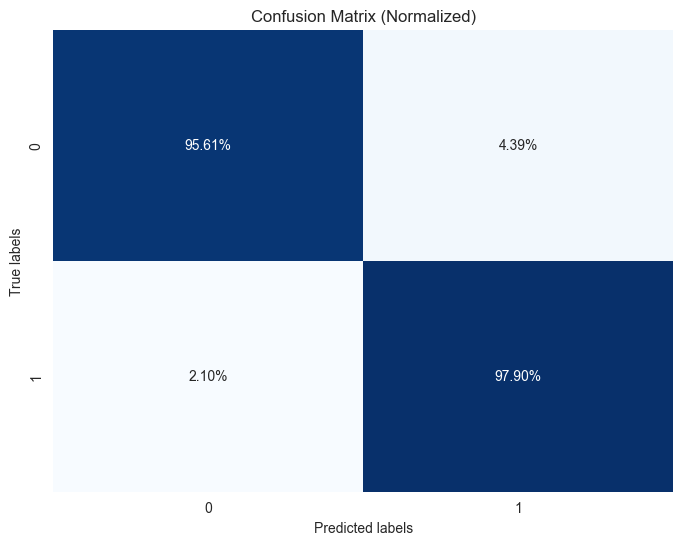

In [31]:
Y_pred = final_model.predict(X_test)

# Normalize the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]  # normalize along the true axis

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()